# Time Series Analysis Problem

### Import required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Import the time series data: Airline Passenger Traffic

In [2]:
data = pd.read_csv('airline-passenger-traffic.csv', header = None)
data.columns = ['Month', 'Passengers']
data['Month'] = pd.to_datetime(data['Month'], format = '%Y-%m')
data =  data.set_index('Month')
data.head(10)

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0
1949-07-01,148.0
1949-08-01,148.0
1949-09-01,136.0


### Plot the time series data

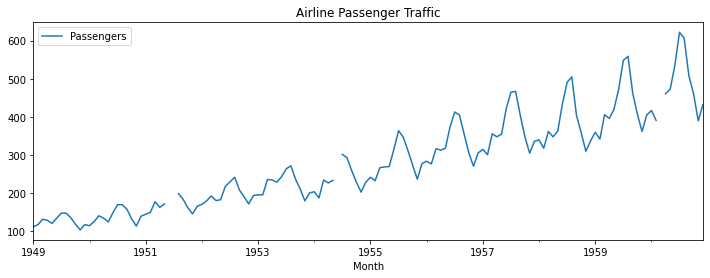

In [3]:
data.plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Airline Passenger Traffic')
plt.show(block=False)

### Missing value treatment

#### Mean imputation

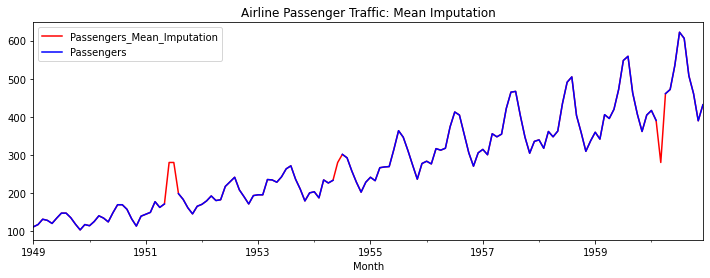

In [4]:
# mean imputation

data = data.assign(Passengers_Mean_Imputation = data.Passengers.fillna(data.Passengers.mean()))
data['Passengers_Mean_Imputation'].plot(figsize=(12,4), color = 'r')
data['Passengers'].plot(figsize=(12,4), color = 'b')

plt.legend(loc = 'best')
plt.title("Airline Passenger Traffic: Mean Imputation")
plt.show(block=False)

#### Linear interpolation

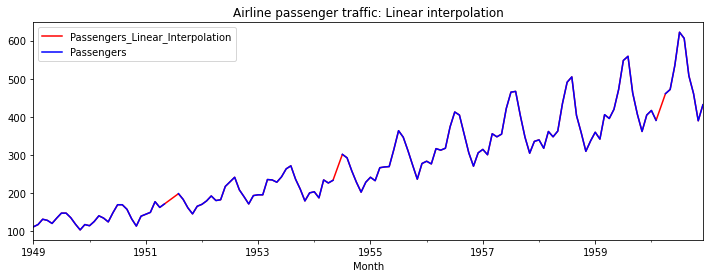

In [5]:
# linear interpolation

data = data.assign(Passengers_Linear_Interpolation=data.Passengers.interpolate(method='linear'))
data['Passengers_Linear_Interpolation'].plot(figsize=(12, 4), color = 'r')
data['Passengers'].plot(figsize=(12,4), color = 'b')

plt.legend(loc='best')
plt.title('Airline passenger traffic: Linear interpolation')
plt.show(block=False)

Linear interpolation is better approach than mean imputation.

#### Use linear interpolation to impute missing values

### Outlier detection

#### Box plot and interquartile range

In [6]:
data['Passengers'] = data['Passengers_Linear_Interpolation']
data.drop(columns=['Passengers_Mean_Imputation','Passengers_Linear_Interpolation'],inplace=True)

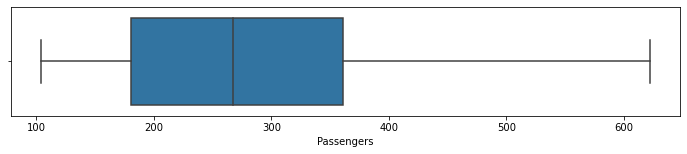

In [7]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['Passengers'], whis = 1.5)

#### Histogram plot

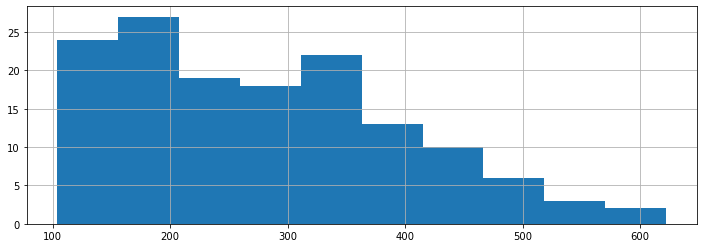

In [8]:
fig = data.Passengers.hist(figsize = (12,4))

#### With describe() method

In [9]:
data.Passengers.describe()

count    144.000000
mean     280.333333
std      120.048359
min      104.000000
25%      180.750000
50%      267.500000
75%      360.500000
max      622.000000
Name: Passengers, dtype: float64

### Time Series Decomposition

#### Additive seasonal decomposition

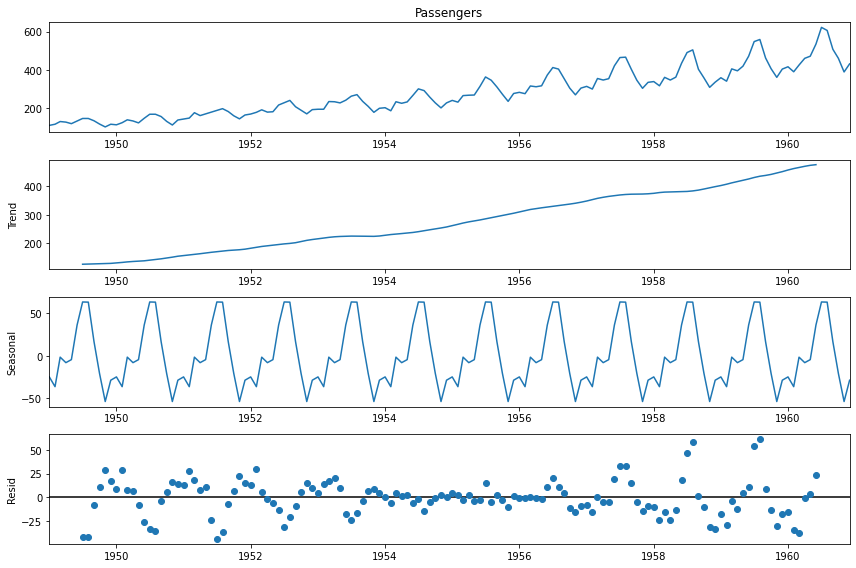

In [10]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data['Passengers'], model= 'additive')
fig = decomposition.plot()
plt.show()

#### Multiplicative seasonal decomposition

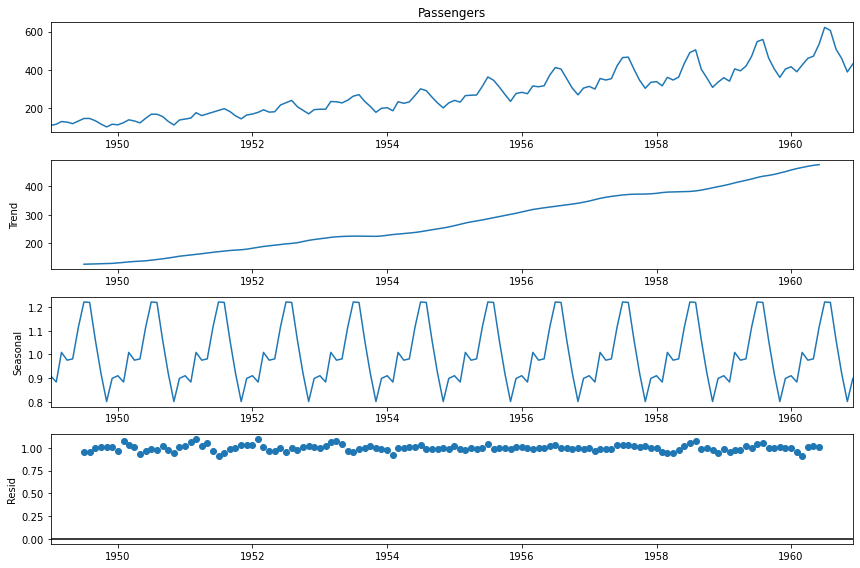

In [11]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

### Build and evaluate the time series forecast

#### training and test set split

In [12]:
# time series train-test split is different from regression train-tes split as the
# data is time dependent
train_len = 120
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

#### Naive method

In [13]:
## Naive method
y_hat_naive = test.copy()
# new column: naive_forecast
# last observation in the train set (train_len-1) element
y_hat_naive['naive_forecast'] = train['Passengers'][train_len-1]

##### Plot train, test and forecast

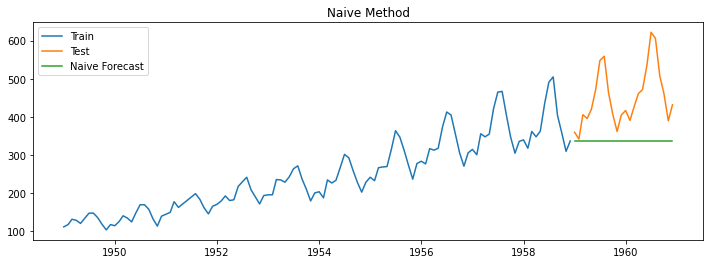

In [14]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive Forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

##### Calculate RMSE and MAPE

In [ ]:
#RMSE and MAPE
from sklearn.metrics import mean_squared_error
#root-mean-square error
rmse = np.sqrt(mean_squared_error(test['Passengers'],y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_naive['naive_forecast'])/test['Passengers'])*100, 2)

results = pd.DataFrame({'Method':['Naive Method'], 'MAPE': [mape],  'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

#### Simple average method

In [15]:
## Simple average method
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Passengers'].mean()

##### Plot train, test and forecast

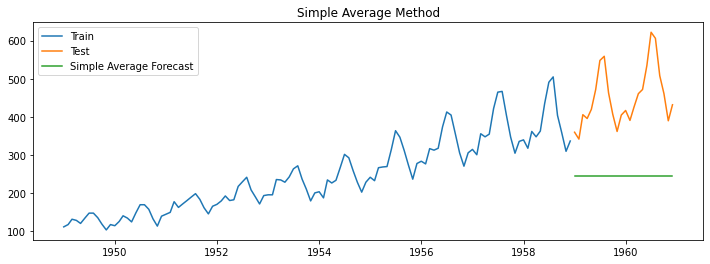

In [16]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple Average Forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

##### Calculate RMSE and MAPE

In [18]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_avg['avg_forecast'])/test['Passengers'])*100, 2)

tempResults = pd.DataFrame({'Method': ['Simple Average Method'], 'RMSE': [rmse], 'MAPE': [mape]})
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28


#### Simple moving average method with 12 months window

In [19]:
## Simple moving average method with 12 months window
y_hat_sma = data.copy() #data is used instead of train/testi set
ma_window = 12
y_hat_sma['sma_forecast_12'] = data['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast_12'][train_len: ] = y_hat_sma['sma_forecast_12'][train_len-1] #for the test period
# train_len is 120 so 121st onwards in sma_forecast is set to the last value in sma_forecast
# y_hat_sma.tail(30)

#### Simple moving average method with 6 months window

In [20]:
## Simple moving average method with 6 months window
# y_hat_sma = data.copy() #data is used instead of train/testi set
ma_window = 6
y_hat_sma['sma_forecast_6'] = data['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast_6'][train_len: ] = y_hat_sma['sma_forecast_6'][train_len-1] #for the test period
# train_len is 120 so 121st onwards in sma_forecast is set to the last value in sma_forecast
# y_hat_sma.tail(30)

#### Simple moving average method with 3 months window

In [21]:
## Simple moving average method with 3 months window
# y_hat_sma = data.copy() #data is used instead of train/testi set
ma_window = 3
y_hat_sma['sma_forecast_3'] = data['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast_3'][train_len: ] = y_hat_sma['sma_forecast_3'][train_len-1] #for the test period
# train_len is 120 so 121st onwards in sma_forecast is set to the last value in sma_forecast
# y_hat_sma.tail(30)

In [22]:
y_hat_sma.tail(30)

,Passengers,sma_forecast_12,sma_forecast_6,sma_forecast_3
Month,,,,
1958-07-01,491.0,376.333333,386.166667,429.666667
1958-08-01,505.0,379.500000,417.333333,477.000000
1958-09-01,404.0,379.500000,424.333333,466.666667
1958-10-01,359.0,380.500000,426.166667,422.666667
1958-11-01,310.0,380.916667,417.333333,357.666667
1958-12-01,337.0,381.000000,401.000000,335.333333
1959-01-01,360.0,381.000000,401.000000,335.333333
1959-02-01,342.0,381.000000,401.000000,335.333333
1959-03-01,406.0,381.000000,401.000000,335.333333


##### Plot train, test and forecast

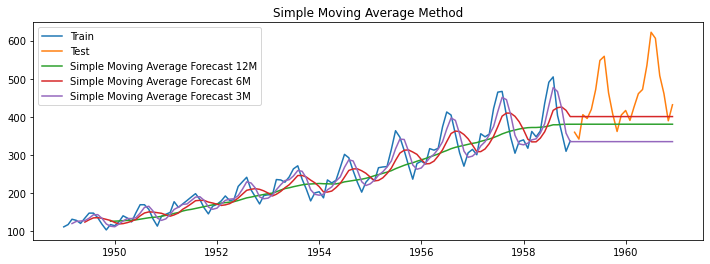

In [23]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')

plt.plot(y_hat_sma['sma_forecast_12'], label='Simple Moving Average Forecast 12M')
plt.plot(y_hat_sma['sma_forecast_6'], label='Simple Moving Average Forecast 6M')
plt.plot(y_hat_sma['sma_forecast_3'], label='Simple Moving Average Forecast 3M')

plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

##### Calculate RMSE and MAPE

In [24]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast_12'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sma['sma_forecast_12'][train_len:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple Moving Average Forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Forecast,103.33,15.54


In [ ]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast_6'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sma['sma_forecast_6'][train_len:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple Moving Average Forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast_3'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sma['sma_forecast_3'][train_len:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple Moving Average Forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

#### Simple exponential smoothing

In [25]:
## Simple exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Passengers'])
model_fit = model.fit(smoothing_level= 0.2, optimized= False)
model_fit.params

y_hat_ses= test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

C:\Users\laksh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


##### Plot train, test and forecast

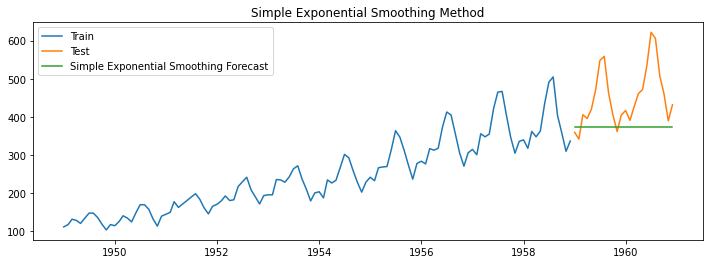

In [26]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple Exponential Smoothing Forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

##### Calculate RMSE and MAPE

In [27]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple Exponential Smoothing Forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Forecast,103.33,15.54
0,Simple Exponential Smoothing Forecast,107.65,16.49


#### Holt's method with trend

In [28]:
## Holt's method with trend
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods =12, trend= 'additive', seasonal=None ) 
#additive because train set follows a linear trend, if geometric or exponential we could use multiplicative trend
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 112.0, 'initial_trend': 6.0, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


##### Plot train, test and forecast

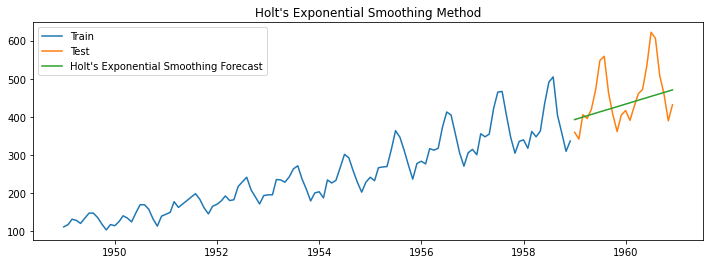

In [29]:
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s Exponential Smoothing Forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

##### Calculate RMSE and MAPE

In [30]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s Exponential Smoothing Method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Forecast,103.33,15.54
0,Simple Exponential Smoothing Forecast,107.65,16.49
0,Holt's Exponential Smoothing Method,71.94,11.11


#### Holt Winters' additive method with trend and seasonality

In [31]:
## Holt Winters' additive method with trend and seasonality
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.23615815135772011, 'smoothing_trend': 0.0, 'smoothing_seasonal': 0.7638418486422799, 'damping_trend': nan, 'initial_level': 204.98775010890893, 'initial_trend': 2.277125578879114, 'initial_seasons': array([ -95.26477839,  -89.72946402,  -77.22895316,  -82.34755114,
        -91.04048136,  -76.87513463,  -64.61027726,  -66.56007629,
        -80.69101219,  -99.57005515, -114.23801844,  -98.02808547]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


##### Plot train, test and forecast

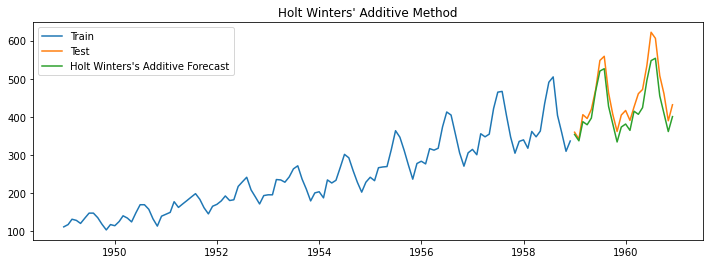

In [32]:
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s Additive Forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

##### Calculate RMSE and MAPE

In [33]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwa['hw_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' Additive Method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Forecast,103.33,15.54
0,Simple Exponential Smoothing Forecast,107.65,16.49
0,Holt's Exponential Smoothing Method,71.94,11.11
0,Holt Winters' Additive Method,35.86,6.72


#### Holt Winter's multiplicative method with trend and seasonality

In [34]:
## Holt Winter's multiplicative method with trend and seasonality
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.3655865614456789, 'smoothing_trend': 8.003382780364158e-08, 'smoothing_seasonal': 0.6344134168549864, 'damping_trend': nan, 'initial_level': 182.90595507171616, 'initial_trend': 3.9608579040286487, 'initial_seasons': array([0.59936353, 0.63043657, 0.69295765, 0.65877107, 0.60804705,
       0.664941  , 0.72308922, 0.71817668, 0.65513481, 0.57089973,
       0.50755226, 0.58555887]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


##### Plot train, test and forecast

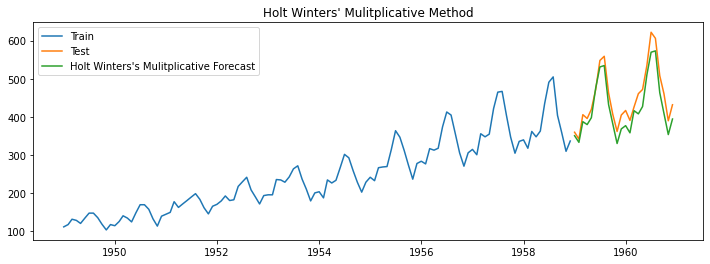

In [35]:
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s Mulitplicative Forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

##### Calculate RMSE and MAPE

In [36]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwm['hw_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' Multiplicative Method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
# results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28
0,Simple Moving Average Forecast,103.33,15.54
0,Simple Exponential Smoothing Forecast,107.65,16.49
0,Holt's Exponential Smoothing Method,71.94,11.11
0,Holt Winters' Additive Method,35.86,6.72
0,Holt Winters' Multiplicative Method,32.46,6.45
